In [3]:
from psrpop import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


def SampleDistance(A, B):
    means_A = A.mean(axis=0)
    vars_A = A.var(axis=0) / 2

    A = (A - means_A) / vars_A
    B = (B - means_A) / vars_A

    nA = len(A)
    nB = len(B)

    diffAB = cdist(A, B).sum()
    diffAA = cdist(A, A).sum()
    diffBB = cdist(B, B).sum()

    return (
        (nA + nB)
        / (nA * nB)
        * (2 * diffAB / (nA * nB) - diffAA / nA**2 - diffBB / nB**2)
    )


def IsNormalPulsar(Ps, Pdots):
    # criterion ms-pulsars

    P1_lower, Pdot1_lower = 0.01, 1e-10  # (P, Pdot)
    P2_lower, Pdot2_lower = 1.0, 1e-19  # (P, Pdot)

    logP1_lower, logPdot1_lower = np.log10(P1_lower), np.log10(Pdot1_lower)
    logP2_lower, logPdot2_lower = np.log10(P2_lower), np.log10(Pdot2_lower)

    slope_lower = (logPdot2_lower - logPdot1_lower) / (logP2_lower - logP1_lower)
    intercept_lower = logPdot1_lower - slope_lower * logP1_lower

    P_line_lower = np.logspace(np.log10(P1_lower), np.log10(P2_lower), 100)
    Pdot_line_lower = 10 ** (slope_lower * np.log10(P_line_lower) + intercept_lower)

    # criterion magnetars

    P1_upper, Pdot1_upper = 0.1, 1e-10
    P2_upper, Pdot2_upper = 10.0, 1e-14

    logP1_upper, logPdot1_upper = np.log10(P1_upper), np.log10(Pdot1_upper)
    logP2_upper, logPdot2_upper = np.log10(P2_upper), np.log10(Pdot2_upper)

    slope_upper = (logPdot2_upper - logPdot1_upper) / (logP2_upper - logP1_upper)
    intercept_upper = logPdot1_upper - slope_upper * logP1_upper

    return (Pdots < 10 ** (slope_upper * np.log10(Ps) + intercept_upper)) & (
        Pdots > 10 ** (slope_lower * np.log10(Ps) + intercept_lower)
    )

Task:
1. Pack the $P$ and $\dot{P}$ into a 2D array and pass to the `SampleDistance` function to get a measure of how similar the distributions are.
2. Plot how that value changes for different values of `nbraking` and/or `beta`.

In [4]:
pulsars = Simulate_Evolution(
    birth_rate=0.2 / 100,
    total_time=1e8,
    nbraking=2.5,
    beta=0.05,
)

In [5]:
catalog = Read_Catalogue()

In [6]:
detectable_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)

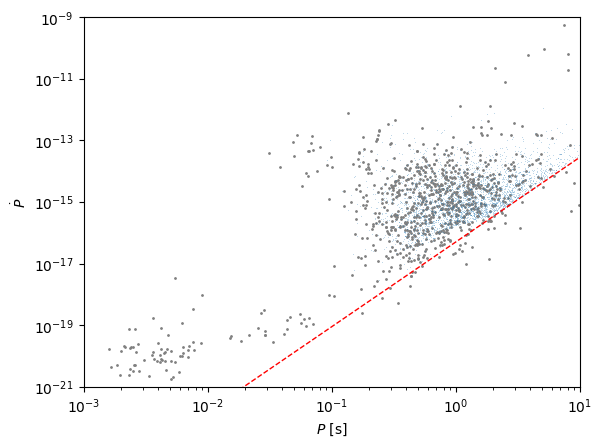

In [7]:
ax = Plot_PPdot(detectable_pulsars, color=None, s=0.1, lw=0)

ax.scatter(
    catalog.P0.astype(float),
    catalog.P1.astype(float),
    s=1,
    color="gray",
    zorder=-1,
)

In [11]:
# pack the data into 2D arrays

real_pulsars_P = np.array(catalog["P0"], dtype=float)
real_pulsars_Pdot = np.array(catalog["P1"], dtype=float)
# real_pulsars_Dist = np.array(catalog["DIST_DM"], dtype=float)

# mask out the nan and negative values
mask = (
    ~np.isnan(real_pulsars_P)
    & ~np.isnan(real_pulsars_Pdot)
    # & ~np.isnan(real_pulsars_Dist)
    & (real_pulsars_P > 0)
    & (real_pulsars_Pdot > 0)
    # & (real_pulsars_Dist > 0)
    & IsNormalPulsar(real_pulsars_P, real_pulsars_Pdot)
)

real_pulsars = np.array(
    [
        np.log(real_pulsars_P[mask]),
        np.log(real_pulsars_Pdot[mask]),
        # real_pulsars_Dist[mask],
    ]
).T
synthetic_pulsars = np.array(
    [
        np.log(detectable_pulsars.Ps),
        np.log(detectable_pulsars.Pdots),
        # detectable_pulsars.distances,
    ]
).T

In [12]:
SampleDistance(real_pulsars, synthetic_pulsars)

np.float64(0.0009127834124941303)

In [18]:
np.linspace(2.5,3.5, 11)

array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5])

In [40]:
n_values = np.linspace(2.5,3.5, 11)
sample_distance_n = []

for n in n_values:
    print("pulsars with n=", n)
    
    pulsars = Simulate_Evolution(
        birth_rate=0.2 / 100,
        total_time=1e8,
        nbraking=n,
        beta=0.05,
    )
    
    detected_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)
    
    real_pulsars = np.array(
        [
            np.log(real_pulsars_P[mask]),
            np.log(real_pulsars_Pdot[mask]),
            # real_pulsars_Dist[mask],
        ]
    ).T
    synthetic_pulsars = np.array(
        [
            np.log(detected_pulsars.Ps),
            np.log(detected_pulsars.Pdots),
            # detectable_pulsars.distances,
        ]
    ).T
    
    d = SampleDistance(real_pulsars, synthetic_pulsars)
    print(d)
    sample_distance_n.append(d)

pulsars with n= 2.5
0.0008889862603881642
pulsars with n= 2.6
0.0010035873348690656
pulsars with n= 2.7
0.000856883597448155
pulsars with n= 2.8
0.000886035895140277
pulsars with n= 2.9
0.0009959719356946064
pulsars with n= 3.0
0.0008114641999987663
pulsars with n= 3.1
0.0008774297108413363
pulsars with n= 3.2
0.0008194132337446572
pulsars with n= 3.3
0.0007779558210780325
pulsars with n= 3.4
0.0007692920412836666
pulsars with n= 3.5
0.0007463586981792413


In [41]:
sample_distance_n

[np.float64(0.0008889862603881642),
 np.float64(0.0010035873348690656),
 np.float64(0.000856883597448155),
 np.float64(0.000886035895140277),
 np.float64(0.0009959719356946064),
 np.float64(0.0008114641999987663),
 np.float64(0.0008774297108413363),
 np.float64(0.0008194132337446572),
 np.float64(0.0007779558210780325),
 np.float64(0.0007692920412836666),
 np.float64(0.0007463586981792413)]

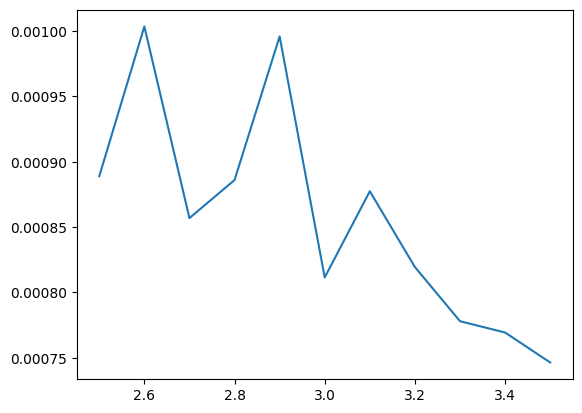

In [42]:
plt.plot(n_values, sample_distance_n)

In [25]:
np.linspace(0.01,0.1, 10)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [43]:
#same thing as above but for beta values instead of n
beta_values = np.linspace(0.01,0.1, 10)
sample_distance_b = []

for beta in beta_values:
    print("pulsars with beta=", beta)
    
    pulsars = Simulate_Evolution(
        birth_rate=0.2 / 100,
        total_time=1e8,
        nbraking=3,
        beta=beta,
    )
    
    detected_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)
    
    real_pulsars = np.array(
        [
            np.log(real_pulsars_P[mask]),
            np.log(real_pulsars_Pdot[mask]),
            # real_pulsars_Dist[mask],
        ]
    ).T
    synthetic_pulsars = np.array(
        [
            np.log(detected_pulsars.Ps),
            np.log(detected_pulsars.Pdots),
            # detectable_pulsars.distances,
        ]
    ).T
    
    d = SampleDistance(real_pulsars, synthetic_pulsars)
    print(d)
    sample_distance_b.append(d)    

pulsars with beta= 0.01
0.0019398707212029682
pulsars with beta= 0.020000000000000004
0.0016324310932839768
pulsars with beta= 0.030000000000000006
0.0012790548693810773
pulsars with beta= 0.04000000000000001
0.001081255157413654
pulsars with beta= 0.05000000000000001
0.0008850500460102284
pulsars with beta= 0.06000000000000001
0.0007776515268495358
pulsars with beta= 0.07
0.0006961335932487769
pulsars with beta= 0.08
0.000514026294244985
pulsars with beta= 0.09000000000000001
0.0005162442325744476
pulsars with beta= 0.1
0.00047592094925990924


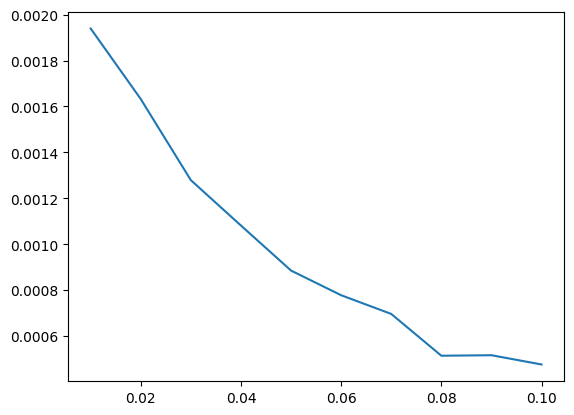

In [44]:
plt.plot(beta_values, sample_distance_b)